## Compute Laplacian

In [1]:
## IMPORT LIBRARIES 
import os
import sys
import igl
import time
import torch
import numpy as np
import meshplot as mp
from typing import Tuple
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## IMPORT SOURCE
from smpl_torch_batch import SMPLModel

In [2]:
## LOAD ANIMATION DATA (ORIGINAL SCANS OF SINGLE INSTANCE)

training_data = torch.load('../data/50004_dataset.pt')
data_loader = torch.utils.data.DataLoader(training_data, batch_size=1, shuffle=False)

device = "cpu"
smpl_model = SMPLModel(device=device, model_path='../body_models/smpl/female/model.pkl')

for data in data_loader:
    target_verts = data[1].squeeze()
    V = np.array(target_verts, dtype=float)
    F = np.array(smpl_model.faces, dtype=int)
    break

frames = 20
with np.load(f"../results/eigdecomp_batch_{frames}_frames.npz") as file:
    V_selected = file['arr_0']
    eigvals = file['arr_3']
    eigvecs = file['arr_4']
    

## Experiments

In [3]:
def generate_sine_wave(
    amplitude: float,
    frequency: float,
    phase: float,
    sampling_rate: int,
    duration: float) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
    """Generates a sine wave

    Args:
        amplitude (float): Amplitude
        frequency (float): Frequnecy [Hz]
        phase (float): Phase [rad]
        sampling_rate (int): Sampling rate[Hz]
        duration (float): Duration [s]

    Returns:
        Tuple[torch.FloatTensor, torch.FloatTensor]: t, y(t)
    """
    total_steps = int(sampling_rate * duration)
    t = torch.linspace(0, duration, total_steps)
    y = amplitude * torch.sin(2 * np.pi * frequency * t + phase)

    return t, y

In [4]:
def get_fft_components(signal, fourier, sampling_rate = 1_000, plot=True):
    absolutes = fourier.abs()
    freq = torch.fft.rfftfreq(len(signal), 1/sampling_rate)
    
    if plot:
        fig, ax = plt.subplots()
        ax.set_xlabel('Frequencies')
        ax.set_ylabel('$|F(s)|$')
        ax.grid()
        ax.scatter(x=freq, y=absolutes, s=8)
        plt.savefig('./plots/fourier_transform_sampling_{}_{}.png'.format(sampling_rate, time.time()))
    
    return absolutes, freq

In [5]:
num_eigvals = eigvals.shape[1]
num_verts = V_selected.shape[1]
duration = V_selected.shape[0]

V_tensor = torch.from_numpy(V_selected)
eigvals_tensor = torch.from_numpy(eigvals.real)
eigvecs_tensor = torch.from_numpy(eigvecs.real)

print(V_tensor.shape, eigvals_tensor.shape, eigvecs_tensor.shape)

torch.Size([20, 6890, 3]) torch.Size([20, 10]) torch.Size([20, 6890, 10])


In [9]:

def get_fft_batch(signal_batch, verbose_idx=-1):
    """
    Signal_batch: nd.array has shape (num_frames, num_verts, num_eigvals)
    
    """
    
    first_dim = signal_batch.shape[1]
    second_dim = signal_batch.shape[2]
    
    fft_batch = []
    for i in range(first_dim):
        eigvecs_abs = []
        eigvecs_freqs = []
        for j in range(second_dim):
            signal = signal_batch[:, i, j]

            signal_fourier = torch.fft.rfft(signal, norm='forward') 
            absolutes, freqs = get_fft_components(signal, signal_fourier, plot=False)

            eigvecs_freqs.append(freqs)
            eigvecs_abs.append(absolutes)
            
        fft_batch.append((eigvecs_freqs, eigvecs_abs))       
        if verbose_idx > 0:
            if (i+1) % verbose_idx == 0:
                print(">> Step ", i+1 , "/", first_dim)
    
    return fft_batch

In [10]:
eigdecomp_anim = get_fft_batch(eigvecs_tensor)
#anim_classic_fft = get_fft_batch(torch.from_numpy(V))

In [11]:
def get_fft_expectation(fft_tuples):
    """
    fft_tuples: Array of Tuples (freqs, abs)
    """
    vertex_fft_exs= []
    num_samples = len(fft_tuples)
    num_freqs = len(fft_tuples[0][0])
    
    for sample in range(num_samples):
        eigvecs_freqs, eigvecs_abs = fft_tuples[sample]
        
        expectation = 0.0
        for freq_idx in range(num_freqs):
            expectation += np.dot(eigvecs_freqs[freq_idx], eigvecs_abs[freq_idx])

        vertex_fft_exs.append(expectation / num_freqs) # record average expectation
        
    return np.array(vertex_fft_exs)

In [12]:
## GET THE EXPECTATION FOR EACH VERTEX
#vertex_fft_exs = get_fft_expectation(anim_classic_fft) --> to check animation vertices' fft rather than laplacian 
vertex_fft_exs = get_fft_expectation(eigdecomp_anim)

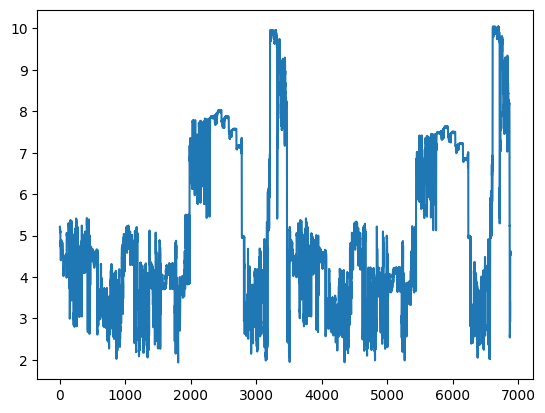

In [13]:
plt.plot(vertex_fft_exs)

In [14]:
#### DEFINE VERTEX SCORES

vertex_scores = vertex_fft_exs

In [19]:
#### NORMALIZE SCORES
def normalize_array(arr):
    normalized_arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return normalized_arr

vertex_scores_normalized = normalize_array(vertex_scores)
print(vertex_scores_normalized.shape)
print("Sanity check 1.0 =", np.max(vertex_scores_normalized), " and 0.0 =", np.min(vertex_scores_normalized))

(6890,)
Sanity check 1.0 = 1.0  and 0.0 = 0.0


In [20]:
#### COLOR CODE SCORES
from matplotlib import cm

"""
# Threshold scores
threshold_idx = vertex_scores_normalized < 0.2

vertex_scores_normalized[threshold_idx] = 1.0
vertex_scores_normalized[np.invert(threshold_idx)] = 0.0
"""

colors = cm.hot(vertex_scores_normalized)[:, :3]
print(colors.shape)

(6890, 3)


In [21]:
# PLOT THE COLOR CODED VERTICES

v_start = V_selected[0]
p = mp.plot(v_start, F)
anim_length = V_selected.shape[0]

for k in range(10):
    for i in range(anim_length):
        
        v_new = V_selected[i]
        p.update_object(vertices=v_new, colors=colors)
        v = v_new
        time.sleep(0.1)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0354125…